In [8]:

import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb

import util
from util import inv_phi_range
from util import FWHM
import model as m

import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from qkeras import QBatchNormalization
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

import hls4ml

In [9]:
phi_div  = 64
eta_div  = 64
pt_div   = 64
qual_div = 64

hidden_neurons = 256
k_reg          = kernel_regularizer=regularizers.l2(1e-4)
a_reg          = kernel_regularizer=regularizers.l2(1e-4)
# ap_fixed       = [18, 5]
ap_fixed       = [24, 8]
target_sparsity = 0.2

n_epochs     = 100
batch_size   = 1024

lr = 1e-4
device = 0

train   = True
pruning = False

ckpt_file      = "checkpoints/run3_uGMT_nn_recal_checkpoint.h5"

In [ ]:
# wandb.login(key="redacted_for_privacy")
# wandb.init(
#     project = "run3_uGMT_recal_keras",
#     name = "redacted_for_privacy",
# )

In [11]:
DATAPATH  = "/home/rardino/data/run3/"
MODELPATH = "./models/run3/"

if not os.path.exists(MODELPATH): os.makedirs(MODELPATH)

/home/diptarko/Refactory/util.py:96: UserWarning: The limits are expected to be the exact float values and not the converted integer counter parts
  warnings.warn("The limits are expected to be the exact float values and not the converted integer counter parts")


train_len =  619108
Train df shape: (619108, 34)
Test  df shape: (32585, 34)
X train shape: (619108, 5)
Y train shape: (619108, 3)
X test  shape: (32585, 5)
Y test  shape: (32585, 3)


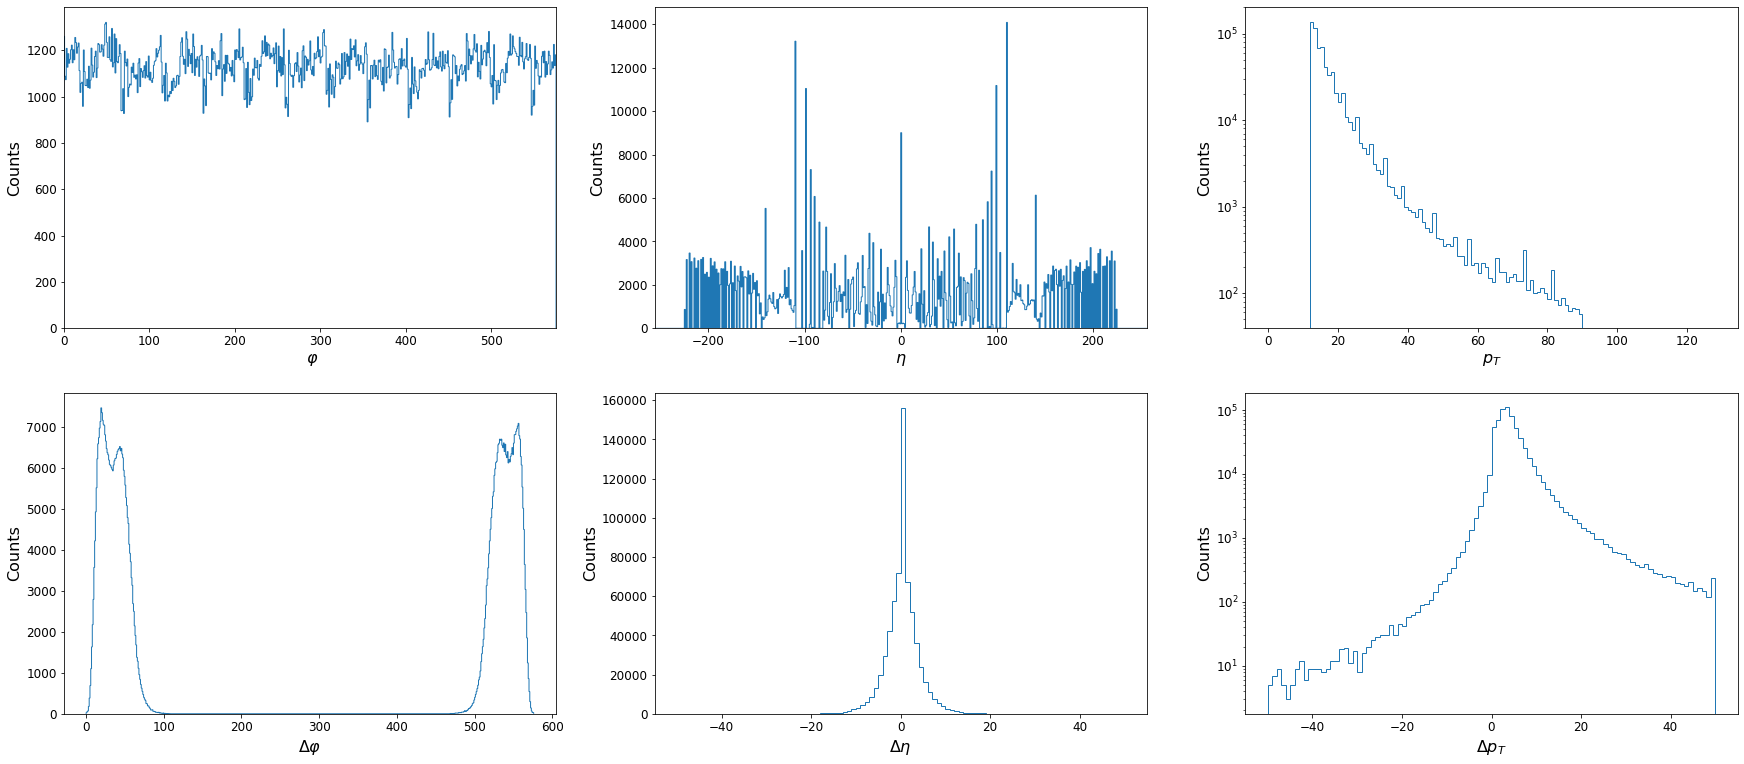

In [146]:
df_base =util.load_data([
    os.path.join(DATAPATH,"run3golden_mm_singles.csv")
                 ])
df_base = util.apply_cut(df_base, 5.5, 45)
train_data, test_data, df_train, df_test = util.preprocess_data(df_base)
x_train, y_train = train_data
x_test, y_test = test_data

#-------------------------------------------------------------------
pt_true_train = np.array(df_train.ptRecoMu1)
pt_true_test = np.array(df_test.ptRecoMu1)
y_train = np.concatenate([y_train,pt_true_train[:,None]],axis = -1)
y_test = np.concatenate([y_test,pt_true_test[:,None]],axis = -1)
#-------------------------------------------------------------------

util.plot_data(df_base)

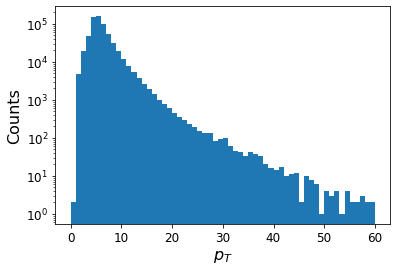

In [147]:
x_lim = [0, 60]
nbins = x_lim[1] - x_lim[0]
dist = plt.hist(y_train[:,-1], bins=nbins, range=x_lim)
plt.xlabel("$p_T$")
plt.ylabel("Counts")
plt.yscale("log")
plt.show()

In [148]:
n_p,p = dist[0],dist[1]
s_p = 1/n_p
scale_dict = {}
for i in range(p.shape[0]-1):
    scale_dict[i+1] = s_p[i]
scale_dict[0] = s_p[0]

for i in range(p.shape[0],int(y_train.max())+1,1):
    scale_dict[i] = 1

In [151]:
y_test = np.concatenate([y_test,np.vectorize(scale_dict.get)(np.array(y_test[:,-1],dtype=np.int32))[:,None]],axis=-1)
y_train = np.concatenate([y_train,np.vectorize(scale_dict.get)(np.array(y_train[:,-1],dtype=np.int32))[:,None]],axis=-1)

In [152]:
model = m.make_model(hidden_neurons=hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed,
                     corrector = True
                    )

if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(target_sparsity, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

opt          = Adam(learning_rate=lr)
losses       = ['logcosh']
loss_weights = [1]

In [153]:
def custom_loss(y_true, y_pred):
    loss = keras.losses.logcosh(y_true[:,2],y_pred[:,0])
    loss = y_true[:,-1]*loss
    return loss  # Note the `axis=-1`

In [154]:
if train:
    early_stopping = EarlyStopping(
        monitor  = 'val_loss',
        patience = 20
    )
    reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               factor=0.5,
                                                               patience=5,
                                                               verbose=1,
                                                               mode="auto",
                                                               min_delta=0.0001,
                                                               cooldown=0,
                                                               min_lr=0)

    checkpoint = ModelCheckpoint(
        MODELPATH + "/qmodel_hl_4__hn_128__qrelu__reg_0p0001l2__ep_20__bs_1024_checkpoint.h5",
        monitor           = 'val_loss',
        verbose           = 1,
        save_best_only    = True,
        save_weights_only = False
    )

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
    callbacks = [
#         early_stopping,
                 reduce_lr_on_plateu]


    callbacks.append(pruning_callbacks.UpdatePruningStep())

    with tf.device(f'/device:GPU:{device}'):    
            model.compile(
                loss         = custom_loss,
#                 loss = lambda x,y: tf.keras.losses.logcosh(x[:,2],y[:,0]),
                optimizer    = opt,
                    metrics=lambda x,y: tf.keras.metrics.logcosh(x[:,2],y[:,0])
            )

            model.fit(
#                 x_train, y_train[:,2],
                x_train, y_train,
                
                callbacks=callbacks,
                batch_size=batch_size,
                epochs=n_epochs,
                validation_split=0.1,
                shuffle=True,
                verbose = 1
                #callbacks = callbacks.callbacks
            )

Epoch 1/100
545/545 [==============================] - 7s 7ms/step - loss: 0.0644 - <lambda>: 0.0059 - val_loss: 0.0379 - val_<lambda>: 0.0221
Epoch 2/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0268 - <lambda>: 0.0033 - val_loss: 0.0196 - val_<lambda>: 0.0081
Epoch 3/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0163 - <lambda>: 0.0027 - val_loss: 0.0138 - val_<lambda>: 0.0036
Epoch 4/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0121 - <lambda>: 0.0023 - val_loss: 0.0107 - val_<lambda>: 0.0022
Epoch 5/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0095 - <lambda>: 0.0022 - val_loss: 0.0083 - val_<lambda>: 0.0021
Epoch 6/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0073 - <lambda>: 0.0022 - val_loss: 0.0064 - val_<lambda>: 0.0021
Epoch 7/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0056 - <lambda>: 0.0022 - val_loss: 0.0048 - val_<lambda>: 0.0020

KeyboardInterrupt: 

In [181]:
model_ns = m.make_model(hidden_neurons=hidden_neurons,
                     k_reg=k_reg,
                     a_reg=a_reg,
                     ap_fixed=ap_fixed,
                     corrector = True
                    )

if pruning:
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(target_sparsity, begin_step=2000, frequency=100)}
    model_ns = prune.prune_low_magnitude(model_ns, **pruning_params)

opt          = Adam(learning_rate=lr)
losses       = ['logcosh']
loss_weights = [1]

In [183]:
if train:
    early_stopping = EarlyStopping(
        monitor  = 'val_loss',
        patience = 20
    )
    reduce_lr_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               factor=0.5,
                                                               patience=5,
                                                               verbose=1,
                                                               mode="auto",
                                                               min_delta=0.0001,
                                                               cooldown=0,
                                                               min_lr=0)

    checkpoint = ModelCheckpoint(
        MODELPATH + "/qmodel_hl_4__hn_128__qrelu__reg_0p0001l2__ep_20__bs_1024_checkpoint.h5",
        monitor           = 'val_loss',
        verbose           = 1,
        save_best_only    = True,
        save_weights_only = False
    )

#     callbacks = [early_stopping, checkpoint,FWHM(x_test,y_test, df_test, True)]
    callbacks = [
#         early_stopping,
                 reduce_lr_on_plateu]


    callbacks.append(pruning_callbacks.UpdatePruningStep())

    with tf.device(f'/device:GPU:{device}'):    
            model_ns.compile(
                loss = 'logcosh',
#                 loss = lambda x,y: tf.keras.losses.logcosh(x[:,2],y[:,0]),
                optimizer    = opt,
#                     metrics='logcoh'
            )

            model_ns.fit(
#                 x_train, y_train[:,2],
                x_train, y_train[:,2],
                
                callbacks=callbacks,
                batch_size=batch_size,
                epochs=n_epochs,
                validation_split=0.1,
                shuffle=True,
                verbose = 1
                #callbacks = callbacks.callbacks
            )

Epoch 1/100
545/545 [==============================] - 5s 6ms/step - loss: 0.1063 - val_loss: 0.0961
Epoch 2/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0915 - val_loss: 0.0868
Epoch 3/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0820 - val_loss: 0.0772
Epoch 4/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0729 - val_loss: 0.0687
Epoch 5/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0644 - val_loss: 0.0602
Epoch 6/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0567 - val_loss: 0.0529
Epoch 7/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0496 - val_loss: 0.0465
Epoch 8/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0432 - val_loss: 0.0401
Epoch 9/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0375 - val_loss: 0.0350
Epoch 10/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0325 - val_lo

545/545 [==============================] - 3s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 79/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 80/100
545/545 [==============================] - 3s 6ms/step - loss: 0.0022 - val_loss: 0.0020

Epoch 00080: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 81/100
545/545 [==============================] - 3s 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 82/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 83/100
545/545 [==============================] - 3s 6ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 84/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 85/100
545/545 [==============================] - 3s 5ms/step - loss: 0.0022 - val_loss: 0.0020

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
Epoch 86/100
545/545 [===============

In [184]:
y_pred = model.predict(x_test, batch_size=2048)
y_pred_ns = model_ns.predict(x_test,batch_size=2048)

y_pred = np.squeeze(y_pred)
y_pred_ns = np.squeeze(y_pred_ns)


delta_pt_pred =  y_pred[:] * pt_div * 0.5
delta_pt_pred_ns =  y_pred_ns[:] * pt_div * 0.5



pt_pred= np.array(df_test['PtL1Mu1'][:] - delta_pt_pred[:])
pt_pred_ns= np.array(df_test['PtL1Mu1'][:] - delta_pt_pred_ns[:])


delta_pt_p = np.array(pt_pred - df_test['ptRecoMu1'][:])
delta_pt_p_ns = np.array(pt_pred_ns - df_test['ptRecoMu1'][:])

In [185]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["ptRecoMu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["NN_ns"] = np.abs(delta_pt_p_ns/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])

In [186]:
X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []
nn_ns_bin = []
nn_ns_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),0.5)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
    nn_ns_ = df_analysis["NN_ns"][idx]
    
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    nn_ns_bin.append(nn_ns_.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))
    nn_ns_bin_std.append(nn_ns_.std()/np.sqrt(nn_ns_.shape[0]))

In [202]:
# x = X_bin
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('axes', labelsize=40) 
# master = nn_bin
# masters = nn_bin_std

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home

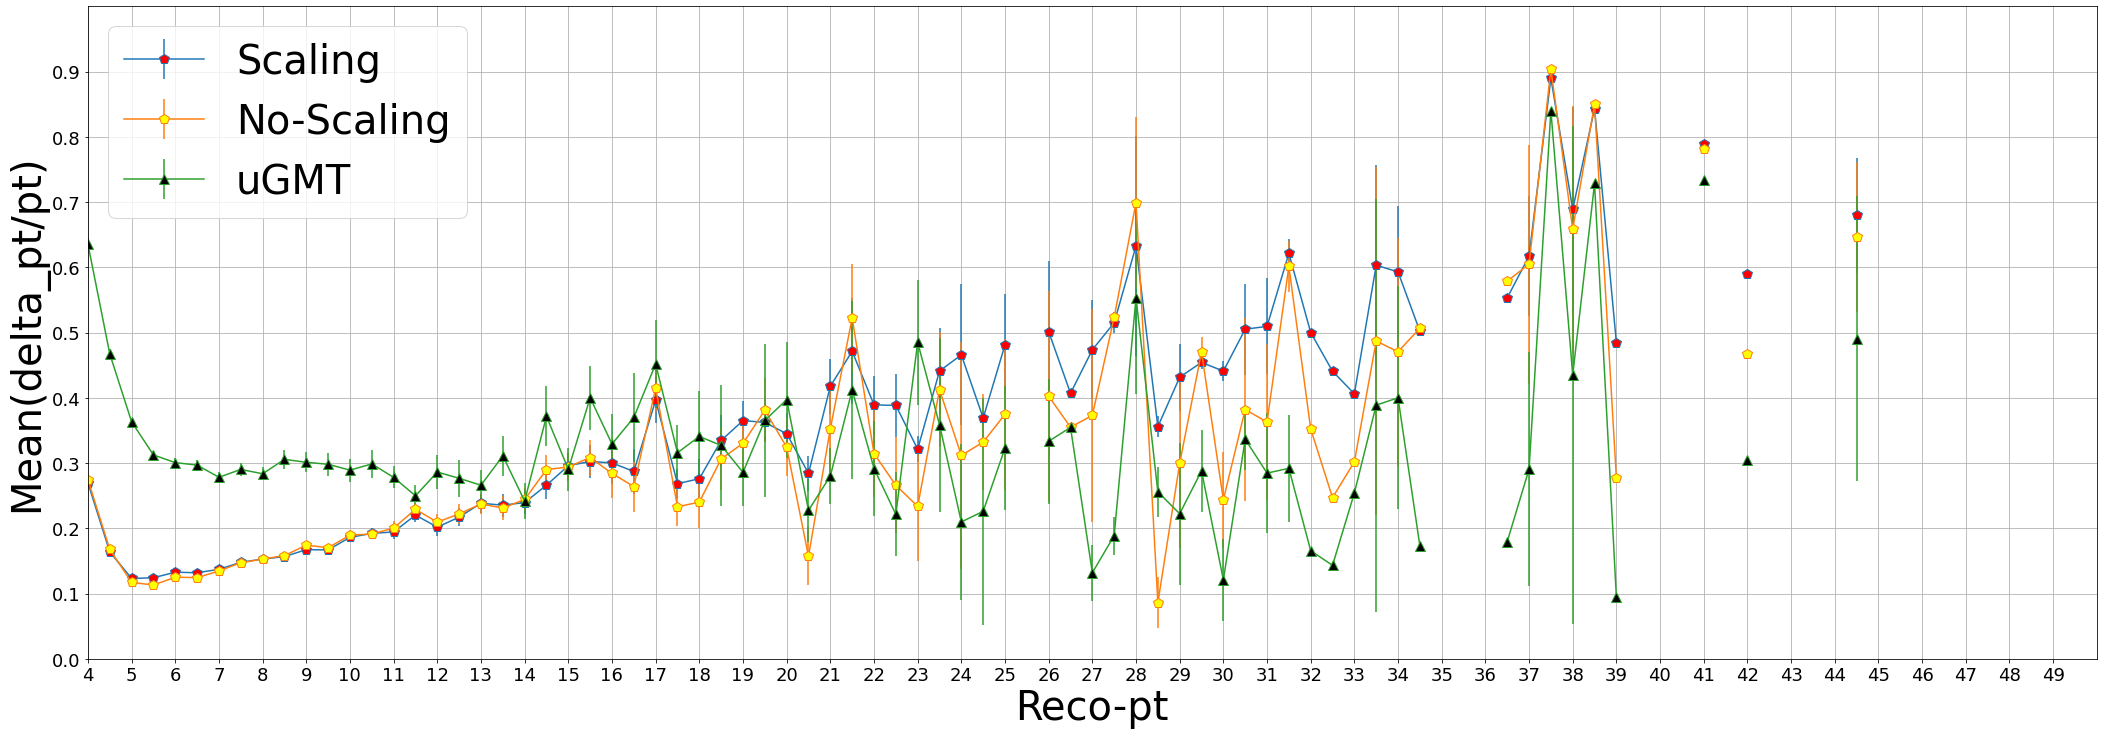

In [205]:
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Scaling",marker = "p",markersize=10,mfc ="red")
plt.errorbar(X_bin,nn_ns_bin, nn_ns_bin_std, label = "No-Scaling",marker = "p",markersize=10,mfc ="yellow")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend(fontsize="40")
plt.xticks(np.arange(0, 50, 1.0))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlim(4,50)
plt.ylim(0,1)
plt.grid(True)
plt.xlabel("Reco-pt")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("scaled_vs_no_scaled.pdf")

In [222]:
bin_dist = 1
df_analysis = pd.DataFrame()
df_analysis["X"] = y_train[:,3]
df_analysis["Y"] = y_train[:,-1]

X_bin = []
Y_bin = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),1)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    y_ = df_analysis["Y"][idx]
    Y_bin.append(y_.mean())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


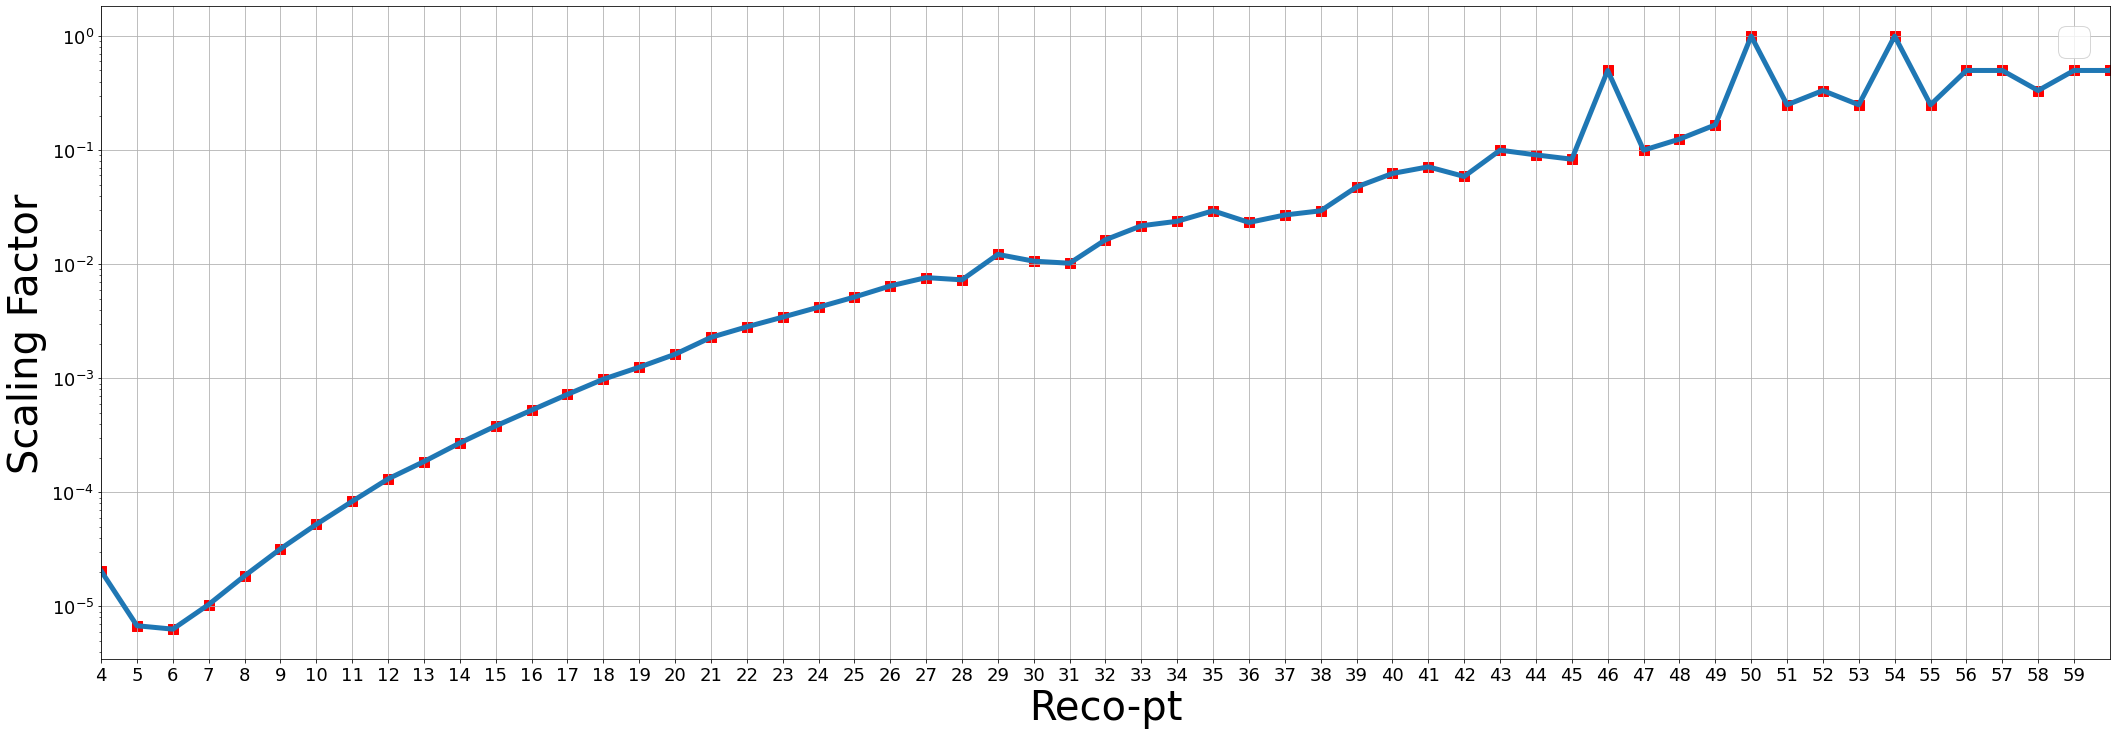

In [239]:
plt.figure(figsize=(36,12))
plt.scatter(X_bin,Y_bin,marker= "s",s=100,c="red")
plt.plot(X_bin,Y_bin,linewidth=5)
plt.legend(fontsize="40")
plt.xticks(np.arange(0, 60, 1.0))
# plt.yticks(np.arange(0, 1, 0.1))
plt.xlim(4,60)
# plt.ylim(0,1)
plt.grid(True)
plt.yscale("log")
plt.xlabel("Reco-pt")
plt.ylabel("Scaling Factor")
plt.savefig("scaling_factor.pdf")

In [191]:
y_train[:,-1].shape

(619108,)

In [44]:
bin_dist = 0.1
df_analysis = pd.DataFrame()
df_analysis["X"] = df_test["hwPtL1Mu1"]
df_analysis["NN"] = np.abs(delta_pt_p/df_test['ptRecoMu1'])
df_analysis["uGMT"] = np.abs(df_test['deltaPt1']/df_test['ptRecoMu1'])
df_analysis = df_analysis.sort_values(by=["X"])

In [45]:
X_bin = []
nn_bin = []
nn_bin_std = []
gmt_bin = []
gmt_bin_std = []

# dist = np.logspace(start=0,stop=df_analysis["X"].max(),num=100,base=1.03)
dist = np.arange(0,df_analysis["X"].max(),2)
for i in range(len(dist)):
    if i+1==len(dist):
        break
    X_bin.append(dist[i])
    idx = (df_analysis["X"]>dist[i]) * (df_analysis["X"]<(dist[i+1]))
    
    nn_ = df_analysis["NN"][idx]
    gmt = df_analysis["uGMT"][idx]
        
    nn_bin.append(nn_.mean())
    gmt_bin.append(gmt.mean())
    
    nn_bin_std.append(nn_.std()/np.sqrt(nn_.shape[0]))
    gmt_bin_std.append(gmt.std()/np.sqrt(gmt.shape[0]))

/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/rardino/tf-gpu-env/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


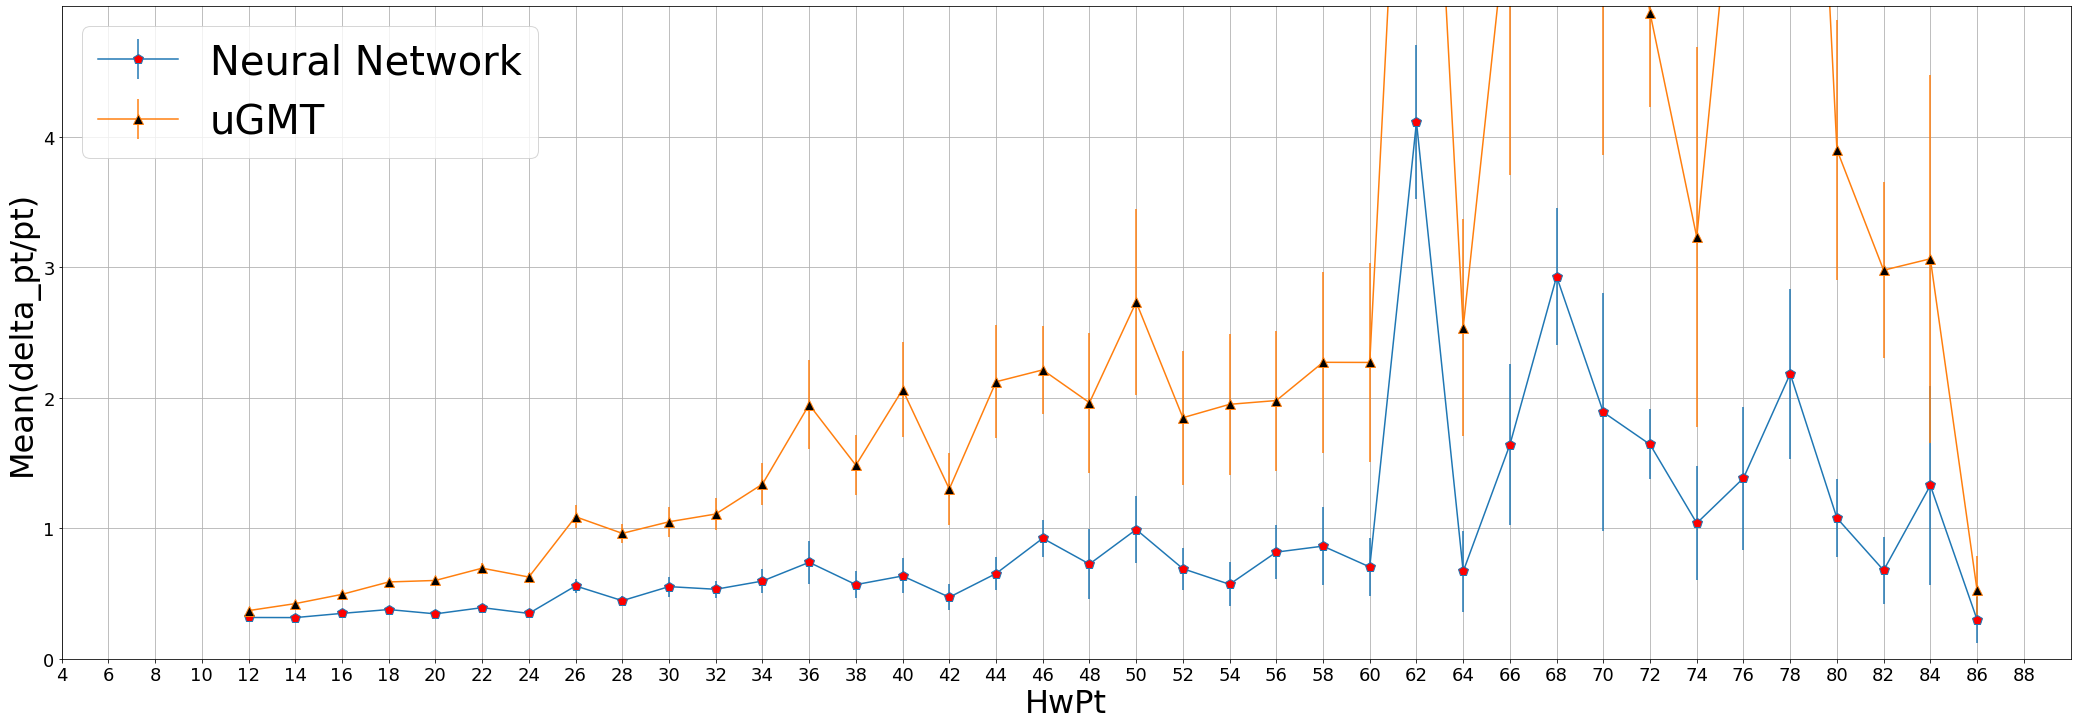

In [50]:
plt.figure(figsize=(36,12))
plt.errorbar(X_bin,nn_bin, nn_bin_std, label = "Neural Network",marker = "p",markersize=10,mfc ="red")
# plt.errorbar(X_bin,master, masters, label = "Master",marker = "p",markersize=10,mfc ="blue")
plt.errorbar(X_bin,gmt_bin,gmt_bin_std, label = "uGMT",marker = "^",markersize=10,mfc="black")
# plt.plot(X_bin,nn_bin)
# plt.plot(X_bin,gmt_bin)
plt.legend()
plt.xticks(np.arange(0, 90, 2))
plt.yticks(np.arange(0, 5, 1))
plt.xlim(4,90)
plt.ylim(0,5)
plt.grid(True)
plt.legend(fontsize="40")
plt.xlabel("HwPt")
plt.ylabel("Mean(delta_pt/pt)")
plt.savefig("Hardware.pdf")

In [86]:
df_analysis["X"]

1930869    12
1691400    12
755230     12
347588     12
1575589    12
           ..
1103024    89
1038801    89
1342140    89
65366      89
1001254    89
Name: X, Length: 32585, dtype: int64